In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import ktrain
from ktrain import tabular
import pandas as pd
pd.set_option('display.max_columns', None)

# Classification for Tabular Data

As of v0.19.x, *ktrain* supports classification (and regression, which is shown later) on "traditional" tabular datasets.

## Solving the Titanic Kaggle Challenge in `ktrain`

This notebook demonstrates using *ktrain* for predicting which passengers survived the Titatnic shipwreck.

The dataset can be [downloaded from Kaggle here](https://www.kaggle.com/c/titanic/overview). There is a `test.csv` with labels (i.e., `Survived`) and a `test.csv` with no labels.  We will only use `train.csv` in this notebook.

Let's begin by loading the data as a pandas DataFrame and inspecting it.

In [3]:
train_df = pd.read_csv('data/titanic/train.csv', index_col=0)

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We'll drop the `Name` and `Ticket` columns, as they seem like they'll be less predictive.

In [5]:
train_df = train_df.drop('Name', 1)
train_df = train_df.drop('Ticket', 1)

*ktrain* will automatically split out a validation set if given only a training set.  But, let's also manually split out a test set that we can evaluate later.

In [6]:
import numpy as np
np.random.seed(42)
p = 0.1 # 10% for test set
prop = 1-p
df = train_df.copy()
msk = np.random.rand(len(df)) < prop
train_df = df[msk]
test_df = df[~msk]

In [7]:
train_df.shape

(799, 9)

In [8]:
test_df.shape

(92, 9)

## STEP 1: Load and Preprocess the Data

In [10]:
trn, val, preproc = tabular.tabular_from_df(train_df, label_columns=['Survived'], random_state=42)

processing train: 717 rows x 9 columns
processing test: 82 rows x 9 columns


*ktrain* automatically preprocesses the dataset appropriately.  Numerical columns are automatically normalized, missing values are handled, and categorical variables will be vectorized as [entity embeddings](https://arxiv.org/abs/1604.06737) for input to a neural network. The processed DataFrame is shown below (categorical variables will be vectorized on-the-fly, so they appear in their original form).

In [11]:
trn.df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,0,1,Age_na
PassengerId,,,,,,,,,,,
1,3,male,-0.583729,1,0,-0.485473,NaN,S,1.0,0.0,False
4,1,female,0.417180,1,0,0.378614,C123,S,0.0,1.0,False
5,3,male,0.417180,0,0,-0.470396,NaN,S,1.0,0.0,False
6,3,male,-0.121771,0,0,-0.462701,NaN,Q,1.0,0.0,True
7,1,male,1.880046,0,0,0.355292,E46,S,1.0,0.0,False


## STEP 2: Create a Model and Wrap in `Learner`

*ktrain* uses multilayer perceptrons as the model for tabular datasets. The model can be configured with arguments to `tabular_classifier` (e.g., number and size of hidden layers, dropout values, etc.), but we will leave the defaults here.

In [12]:
tabular.print_tabular_classifiers()

mlp: a configurable multilayer perceptron with categorical variable embeddings [https://arxiv.org/abs/1604.06737]


In [13]:
model = tabular.tabular_classifier('mlp', trn)

Is Multi-Label? False
done.


In [14]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

## STEP 3: Estimate the Learning Rate

Based on the plot, we will choose a learning rate of `1e-3`.

simulating training for different learning rates... this may take a few moments...
Train for 22 steps
Epoch 1/8
22/22 [==============================] - 2s 79ms/step - loss: 1.4607 - accuracy: 0.4759
Epoch 2/8
22/22 [==============================] - 1s 24ms/step - loss: 1.3271 - accuracy: 0.5036
Epoch 3/8
22/22 [==============================] - 1s 24ms/step - loss: 1.1657 - accuracy: 0.5591
Epoch 4/8
22/22 [==============================] - 1s 24ms/step - loss: 0.9790 - accuracy: 0.6934
Epoch 5/8
22/22 [==============================] - 1s 24ms/step - loss: 0.9297 - accuracy: 0.7051
Epoch 6/8
22/22 [==============================] - 1s 24ms/step - loss: 1.5030 - accuracy: 0.7066
Epoch 7/8
22/22 [==============================] - 1s 23ms/step - loss: 9.5301 - accuracy: 0.6409


done.
Visually inspect loss plot and select learning rate associated with falling loss


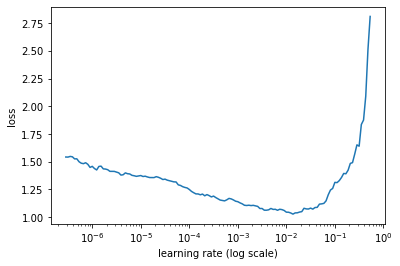

In [15]:
learner.lr_find(show_plot=True, max_epochs=8)

## STEP 4: Train the Model

In [16]:
learner.fit_onecycle(1e-3, 28)



begin training using onecycle policy with max lr of 0.001...
Train for 23 steps, validate for 3 steps
Epoch 1/28
23/23 [==============================] - 2s 86ms/step - loss: 1.1019 - accuracy: 0.6499 - val_loss: 0.6573 - val_accuracy: 0.6951
Epoch 2/28
23/23 [==============================] - 1s 27ms/step - loss: 0.8955 - accuracy: 0.6876 - val_loss: 0.6612 - val_accuracy: 0.5976
Epoch 3/28
23/23 [==============================] - 1s 28ms/step - loss: 0.7901 - accuracy: 0.7364 - val_loss: 0.6511 - val_accuracy: 0.5976
Epoch 4/28
23/23 [==============================] - 1s 28ms/step - loss: 0.7784 - accuracy: 0.7197 - val_loss: 0.6520 - val_accuracy: 0.5976
Epoch 5/28
23/23 [==============================] - 1s 27ms/step - loss: 0.6866 - accuracy: 0.7503 - val_loss: 0.6445 - val_accuracy: 0.5976
Epoch 6/28
23/23 [==============================] - 1s 26ms/step - loss: 0.6190 - accuracy: 0.7768 - val_loss: 0.6447 - val_accuracy: 0.5976
Epoch 7/28
23/23 [==============================] 

**Let's evaluate the validation set:**

In [17]:
learner.evaluate(val, class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        49
           1       0.93      0.79      0.85        33

    accuracy                           0.89        82
   macro avg       0.90      0.87      0.88        82
weighted avg       0.89      0.89      0.89        82



array([[47,  2],
       [ 7, 26]])

## Make Predictions

The `Predictor` for tabular datasets accepts input as a dataframe in the same format as the original training dataframe. 

We will use `test_df` that we created earlier.

In [19]:
p = ktrain.get_predictor(learner.model, preproc)

In [26]:
preds = p.predict(test_df, return_proba=True)

In [40]:
preds.shape

(92, 2)

In [43]:
print('test accuracy:')
(np.argmax(preds, axis=1) == test_df['Survived'].values).sum()/test_df.shape[0]

test accuracy:


0.8695652173913043

**Our final results as a DataFrame:**

In [42]:
df = test_df.copy()[[c for c in test_df.columns.values if c != 'Survived']]
df['Survived'] = test_df['Survived']
df['predicted_Survived'] = np.argmax(preds, axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,predicted_Survived,Survived
PassengerId,,,,,,,,,,
2,1,female,38.0,1,0,71.2833,C85,C,1,1
12,1,female,58.0,0,0,26.5500,C103,S,1,1
34,2,male,66.0,0,0,10.5000,NaN,S,0,0
35,1,male,28.0,1,0,82.1708,NaN,C,0,0
44,2,female,3.0,1,2,41.5792,NaN,C,1,1
